# Model Definition and Result Analysis

Now we are ready to start defining and training our machine learning models to accomplish the task of predicting borrowers whom will likely default in an application. As we have stated before, since we do not have balanced classes, we need to base our approaches using imbalance learning, that is, a technique that deals with imbalanced datasets. Basically, we use a **sampling** technique, for example oversampling or undersampling where data can be increased / decreased artificially to induce less erros in classification task. The task of choosing the right model is also a difficult one and metrics should be evaluated considering this intrinsic characteristic of data. During development of notebook I will dive into a more detailed discussion.

## Importing Libraries and Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('../src')

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score, precision_score, make_scorer
from lightgbm import LGBMClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn import pipeline as imb_pipeline

from sklego.preprocessing import ColumnCapper

# custom functions and classes
from features import NewFeatureTransformer
from preprocess import label_encoder

pd.set_option("max_columns", 100)

In [3]:
df_loan = pd.read_csv("../data/preprocessed/df_loan_filtered.csv")
df_loan.head(5)

,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,issue_d,dti,application_type,loan_status_general,credit_time_in_years,total_loan_amount,installment_to_income,total_loan_to_income
0,36,22.35,1151.16,D,D5,MORTGAGE,100000.0,2018-12-01,30.46,Joint App,fully_paid,6.92,2108.373804,13.813920,0.702791
1,60,16.14,975.71,C,C4,MORTGAGE,45000.0,2018-12-01,50.53,Joint App,fully_paid,9.50,2061.720858,26.018933,0.916320
2,36,7.56,622.68,A,A3,MORTGAGE,100000.0,2018-12-01,18.92,Joint App,fully_paid,19.83,774.849393,7.472160,0.258283
3,36,11.31,147.99,B,B3,RENT,38500.0,2018-12-01,4.64,Individual,fully_paid,15.00,204.096200,4.612675,0.176707
4,36,27.27,345.18,E,E5,MORTGAGE,155000.0,2018-12-01,12.37,Joint App,fully_paid,21.17,711.580039,2.672361,0.153028


## Pipelines

Let's start with preprocessing pipelines. Since I will try three different model concepts: linear, boosting and bagging, they will require different strategies of preprocessing. Logistic Regression models need to use OneHotEncoder for discrete variables while LabelEncode is sufficient for boosting and bagging trees. Linear models also needs data to be scaled as well.

In [4]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
ohc = OneHotEncoder(handle_unknown='ignore', sparse=True)

categorical_cols = ["grade", "sub_grade", "home_ownership", "application_type"]
numeric_cols = df_loan.select_dtypes(exclude='object').columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", imputer),
    ("scaler", StandardScaler())
])

ohc_cols_pipeline = Pipeline(steps=[
    ("ohc", ohc)
])

linear_ct = ColumnTransformer([
    ("new_features", numeric_transformer, numeric_cols),
    ("categorical_cols", ohc_cols_pipeline, categorical_cols)
    ], 
    remainder='drop'
)

In [5]:
pd.DataFrame(linear_ct.fit_transform(df_loan.head(5)))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,-0.5,0.757587,1.340511,0.288701,0.442328,-1.355900,1.213771,0.343176,0.843002,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2.0,-0.109783,0.872574,-1.002237,1.696925,-0.893417,1.153289,1.789515,1.531714,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.5,-1.308179,-0.068981,0.288701,-0.279049,0.958308,-0.515034,-0.408346,-0.590705,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.5,-0.784404,-1.335012,-1.154802,-1.171707,0.092497,-1.254969,-0.747206,-0.853820,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,-0.5,1.444779,-0.809092,1.579638,-0.688497,1.198512,-0.597058,-0.977140,-0.930192,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


To work with trees, we need to label encoder categorical variables.

In [6]:
df_loan.head(4)

,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,issue_d,dti,application_type,loan_status_general,credit_time_in_years,total_loan_amount,installment_to_income,total_loan_to_income
0,36,22.35,1151.16,D,D5,MORTGAGE,100000.0,2018-12-01,30.46,Joint App,fully_paid,6.92,2108.373804,13.813920,0.702791
1,60,16.14,975.71,C,C4,MORTGAGE,45000.0,2018-12-01,50.53,Joint App,fully_paid,9.50,2061.720858,26.018933,0.916320
2,36,7.56,622.68,A,A3,MORTGAGE,100000.0,2018-12-01,18.92,Joint App,fully_paid,19.83,774.849393,7.472160,0.258283
3,36,11.31,147.99,B,B3,RENT,38500.0,2018-12-01,4.64,Individual,fully_paid,15.00,204.096200,4.612675,0.176707


To finish, transform target variable. I will call a default application to be 1 and a fully_paid to be 0.

In [7]:
df_loan["loan_status_general"] = df_loan["loan_status_general"].apply(lambda x: 1 if x=='default' else 0)

### Train-Test splits and Baseline model

I've mentioned before that we can try different type of validation, usually is used a random validation, but we have in our data a temporal factor, and I think we should always validate our models based on time. Of course, I could do both, but I will choose temporal one because it seems more realistic. In a real scenario does not hurt trying both.

In [8]:
train_rand, test_rand = train_test_split(df_loan, test_size=0.20, random_state=20)
train_temp, test_temp = train_test_split(df_loan.sort_values(by='issue_d', ascending=True), test_size=0.20, random_state=20, shuffle=False)

In [9]:
pd.DataFrame({'train_distribution': train_temp['loan_status_general'].value_counts(normalize=True),
             'test_distribution':test_temp['loan_status_general'].value_counts(normalize=True)})

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,train_distribution,test_distribution
0,0.798433,0.735926
1,0.201567,0.264074


In [10]:
pd.DataFrame({'train_distribution': train_rand['loan_status_general'].value_counts(normalize=True),
             'test_distribution':test_rand['loan_status_general'].value_counts(normalize=True)})

,train_distribution,test_distribution
0,0.785923,0.785965
1,0.214077,0.214035


We can already see their difference regarding test distribution, and since in any real scenario I would train models with data up to today to predict tomorrow, why not simulate that in the past as well? 

I also would like to point out other problems such as gap time between default and when an application is proceed, because earlier we defined late to be a default as well.

Before starting any type of modelling process, we need to define a baseline model. In classification tasks usually baseline means predicting every instance in your test data using the majority class, in this case, 0 (fully paid application).

From distribution above, if we just predicted everyone to be a fully paid application, we would get an accuracy of 73% based on test data. So this is our baseline for accuracy metric, however, since we discussed it in this introduction, we have a problem regarding imbalance dataset, so we need to optimize other kind of metrics and curves such as precision, recall, f1-score, ROC and so on. Let's calculate how other relevant metrics would get for a simple baseline model.

In [11]:
predictions = np.zeros(test_temp.shape[0])
print(classification_report(test_temp['loan_status_general'], predictions))

/home/v086200/anaconda3/envs/ifood/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.74      1.00      0.85    195504
           1       0.00      0.00      0.00     70153

    accuracy                           0.74    265657
   macro avg       0.37      0.50      0.42    265657
weighted avg       0.54      0.74      0.62    265657



### Model Definition

We need to define a model that will have a good predictive power in our data. To accomplish that, we need to define and test different models performance. Beyond that, we also need to deal with imbalanced target data, and we will do that using sampling techniques, such as oversampling and undersampling. But I also will use models with no sampling, so we have a lot of models to try, let's start it.

In [12]:
target = 'loan_status_general'
features = [col for col in df_loan.columns if col not in [target, 'issue_d']]

train_temp, test_temp = label_encoder(train_temp, test_temp, columns=categorical_cols)

#### Raw Models

What I call raw pipelines here are models with no sampling technique aggregated to it. I will try three models only: Random Forests (Bagging), Gradient Boosting (LGBM) and Logistic Regression (Linear). These models were chosen because they represent different approaches inside machine learning, they are very robust and well studied. Also, it is always good to compare linear and non-linear models.

In [13]:
lr_pipeline = make_pipeline(linear_ct,
                            LogisticRegression(max_iter=10_000))

rf_pipeline = make_pipeline(SimpleImputer(strategy='median'), RandomForestClassifier())
lgbm_pipeline = make_pipeline(LGBMClassifier())

### Sampling Methods

#### Oversampling

 - **Random Oversampling**: essentially, this technique increases minority class by randomly sampling it.
 - **SMOTE**: random oversampling has a ovelgbmitting problem as we are just replicating data considerably. To overcome that, smote works, in a simplified way, interpolating points on the feature space for nearest neighbors in minority classes.

In [14]:
lr_pipeline_ro = imb_pipeline.make_pipeline(linear_ct, RandomOverSampler(), LogisticRegression())
rf_pipeline_ro = imb_pipeline.make_pipeline(SimpleImputer(strategy='median'), RandomOverSampler(), RandomForestClassifier())
lgbm_pipeline_ro = imb_pipeline.make_pipeline(RandomOverSampler(), LGBMClassifier())

In [15]:
lr_pipeline_smote = imb_pipeline.make_pipeline(linear_ct, SMOTE(), LogisticRegression(max_iter=10_000))
rf_pipeline_smote = imb_pipeline.make_pipeline(SimpleImputer(strategy='median'), SMOTENC(categorical_features=[23, 25]), RandomForestClassifier())
lgbm_pipeline_smote = imb_pipeline.make_pipeline(SimpleImputer(strategy='median'), SMOTENC(categorical_features=[23, 25]), LGBMClassifier())

### Undersampling

For undersampling techniques, we will also choose three of the most famous and assess results.
 - **Random Undersampling:** this method simple undersample the majority class. We can loss information, but if points are close, it can give good results
 - **NearMiss**: In a simplified way, this model selects the closest points to the minority class.

In [16]:
lr_pipeline_ru = imb_pipeline.make_pipeline(linear_ct, RandomUnderSampler(), LogisticRegression())
rf_pipeline_ru = imb_pipeline.make_pipeline(SimpleImputer(strategy='mean'), RandomUnderSampler(), RandomForestClassifier())
lgbm_pipeline_ru = imb_pipeline.make_pipeline(RandomUnderSampler(), LGBMClassifier())

In [17]:
lr_pipeline_nm = imb_pipeline.make_pipeline(linear_ct, NearMiss(), LogisticRegression())
rf_pipeline_nm = imb_pipeline.make_pipeline(SimpleImputer(strategy='mean'), NearMiss(), RandomForestClassifier())
lgbm_pipeline_nm = imb_pipeline.make_pipeline(SimpleImputer(strategy='mean'), NearMiss(), LGBMClassifier())

## Model Training and Hyperparameter Tuning

Now that all our pipelines are defined, we can start training our models and tune hyperparameter. I will tune parameters using cross-validation inside training data, for now I will optimize and choose best model based on f1_score that takes into account both recall and precision.

Also, it is important to notice that I will not do here an exhaustive tuning, this just for demonstrating purposes.

In [20]:
train_cv_temp, test_cv_temp = train_test_split(train_temp.sort_values(by='issue_d').sample(frac=0.01), random_state=20, shuffle=False, test_size=0.2)

def temporal_cv():
    yield train_cv_temp.reset_index().index, test_cv_temp.reset_index().index

In [21]:
train_cv_temp.shape, test_cv_temp.shape

((8500, 15), (2126, 15))

### Logistic Regression Models

In [22]:
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1_score': make_scorer(f1_score)
    }

lr_param_grid = {
    'logisticregression__solver':['liblinear'],
    'logisticregression__penalty': ('l1', 'l2'),
    'logisticregression__C':(0.1, 1, 5, 10, 50),
    'logisticregression__class_weight':('balanced', None)
}

lr_cv = GridSearchCV(lr_pipeline, scoring=scoring, param_grid=lr_param_grid, cv=temporal_cv(), refit='f1_score', n_jobs=-1)
lr_cv.fit(train_temp[features], train_temp[target]);

In [23]:
lr_ro_cv = GridSearchCV(lr_pipeline_ro, scoring=scoring, param_grid=lr_param_grid, cv=temporal_cv(), refit='f1_score', n_jobs=-1)
lr_ro_cv.fit(train_temp[features], train_temp[target]);

In [ ]:
lr_smote_cv = GridSearchCV(lr_pipeline_smote, scoring=scoring, param_grid=lr_param_grid, cv=temporal_cv(), refit='f1_score')
lr_smote_cv.fit(train_temp[features], train_temp[target]);

In [ ]:
lr_ru_cv = GridSearchCV(lr_pipeline_ru, scoring=scoring, param_grid=lr_param_grid, cv=temporal_cv(), refit='f1_score')
lr_ru_cv.fit(train_temp[features], train_temp[target]);

In [ ]:
lr_nm_cv = GridSearchCV(lr_pipeline_nm, scoring=scoring, param_grid=lr_param_grid, cv=temporal_cv(), refit='f1_score')
lr_nm_cv.fit(train_temp[features], train_temp[target]);

In [ ]:
logistic_cv_models = {"LR": lr_cv, "LR_RO": lr_ro_cv, "LR_SMOTE": lr_smote_cv, "LR_RU": lr_ru_cv, "LR_NM": lr_nm_cv}

In [ ]:
def return_table_results(model):
    return pd.DataFrame({"Parameters": model.best_params_, "Score": model.best_score_})
    
for lr_name, lr_model in logistic_cv_models.items():
    print(f"Summary resuls for model: {lr_name}")
    print(return_table_results(lr_model))
    print("-"*78)

### Random Forest Models

In [24]:
rf_param_grid = {
    'randomforestclassifier__n_estimators': [100],
    'randomforestclassifier__max_depth':[10, 20],
    'randomforestclassifier__max_features':[0.5, 0.85],
    'randomforestclassifier__bootstrap':[False, True],
    # 'randomforestclassifier__min_samples_leaf':[1, 5],
    'randomforestclassifier__class_weight':[None, 'balanced']
}

rf_cv = GridSearchCV(rf_pipeline, scoring=scoring, param_grid=rf_param_grid, cv=temporal_cv(), refit='f1_score')
rf_cv.fit(train_temp[features], train_temp[target]);

In [50]:
rf_ro_cv = GridSearchCV(rf_pipeline_ro, scoring=scoring, param_grid=rf_param_grid, cv=temporal_cv(), refit='f1_score')
rf_ro_cv.fit(train_temp[features], train_temp[target]);

In [ ]:
rf_smote_cv = GridSearchCV(rf_pipeline_smote, scoring=scoring, param_grid=rf_param_grid, cv=temporal_cv(), refit='f1_score')
rf_smote_cv.fit(train_temp[features], train_temp[target]);

In [27]:
rf_ru_cv = GridSearchCV(rf_pipeline_ru, scoring=scoring, param_grid=rf_param_grid, cv=temporal_cv(), refit='f1_score')
rf_ru_cv.fit(train_temp[features], train_temp[target]);

In [ ]:
rf_nm_cv = GridSearchCV(rf_pipeline_nm, scoring=scoring, param_grid=rf_param_grid, cv=temporal_cv(), refit='f1_score')
rf_nm_cv.fit(train_temp[features], train_temp[target]);

### Gradient Boosting Models

In [30]:
lgbm_param_grid = {
    'lgbmclassifier__n_estimators': [50, 100, 150],
    'lgbmclassifier__learning_rate': [0.1, 0.9, 0.01],
    'lgbmclassifier__max_depth':[5, 10],
    'lgbmclassifier__subsample':[0.7, 1.0],
    'lgbmclassifier__max_features':[0.5, 1.0],
    'lgbmclassifier__min_samples_leaf':[5],
    'lgbmclassifier__class_weight':[None, 'balanced']
}

lgbm_cv = GridSearchCV(lgbm_pipeline, scoring=scoring, param_grid=lgbm_param_grid, cv=temporal_cv(), refit='f1_score', n_jobs=-1)
lgbm_cv.fit(train_temp[features], train_temp[target]);

In [31]:
lgbm_ro_cv = GridSearchCV(lgbm_pipeline_ro, scoring=scoring, param_grid=lgbm_param_grid, cv=temporal_cv(), refit='f1_score', n_jobs=-1)
lgbm_ro_cv.fit(train_temp[features], train_temp[target]);

In [ ]:
lgbm_smote_cv = GridSearchCV(lgbm_pipeline_smote, scoring=scoring, param_grid=lgbm_param_grid, cv=3, refit='f1_score')
lgbm_smote_cv.fit(train[features], train[target]);

In [ ]:
lgbm_ru_cv = GridSearchCV(lgbm_pipeline_ru, scoring=scoring, param_grid=lgbm_param_grid, cv=3, refit='f1_score')
lgbm_ru_cv.fit(train[features], train[target]);

In [ ]:
lgbm_nm_cv = GridSearchCV(lgbm_pipeline_nm, scoring=scoring, param_grid=lgbm_param_grid, cv=3, refit='f1_score')
lgbm_nm_cv.fit(train[features], train[target]);

In [ ]:
lgbm_cv_models = {"lgbm": lgbm_cv, "lgbm_RO": lgbm_ro_cv, "lgbm_SMOTE": lgbm_smote_cv, "lgbm_RU":lgbm_ru_cv, "lgbm_NM": lgbm_nm_cv}

In [ ]:
for lgbm_name, lgbm_model in lgbm_cv_models.items():
    print(f"Summary resuls for model: {lgbm_name}")
    print(return_table_results(lgbm_model))
    print("-"*78)

Unfortunately, due to the size of dataset and time to build the case, I couldn't do in time a hyperparameter tuning, so I will choose a few parameters based on past experience, and I think I demonstrated this step with code above. Also, we could use AutoMl, Bayesian Optimization or even RandomGrid that are strong and effective options for tuning.

## Result Analysis

In [33]:
lr_pipeline_ro.set_params(**lr_ro_cv.best_params_)
lr_pipeline.set_params(**lr_cv.best_params_)

rf_pipeline.set_params(**rf_cv.best_params_)
rf_pipeline_ru.set_params(**rf_ru_cv.best_params_)

lgbm_pipeline.set_params(**lgbm_cv.best_params_)
lgbm_pipeline_ro.set_params(**lgbm_ro_cv.best_params_)

best_models = {
    "LR": lr_pipeline,
    "LR_RO": lr_pipeline_ro,
    "RF": rf_pipeline,
    "RF_RU": rf_pipeline_ru,
    "LGBM_RO": lgbm_pipeline_ro,
    "LGBM": lgbm_pipeline
}

for model in best_models.values():
    model.fit(train_temp[features], train_temp[target])

Confusion matrix and classification report for model: LR_SMOTE
              precision    recall  f1-score   support

           0       0.83      0.64      0.72    195504
           1       0.38      0.63      0.48     70153

    accuracy                           0.64    265657
   macro avg       0.61      0.63      0.60    265657
weighted avg       0.71      0.64      0.66    265657



DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd1e424aad0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd1e424aad0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


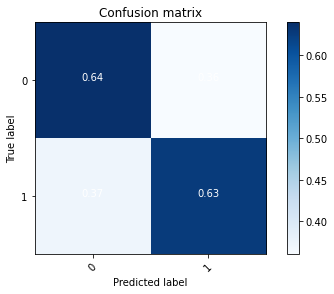

In [42]:
import logging

logging.basicConfig(level=logging.NOTSET)
from visualize import plot_confusion_matrix, plot_roc_curve

def print_summary(model_name, model_pipeline):
    print(f"Confusion matrix and classification report for model: {model_name}")
    
    y_pred = model_pipeline.predict(test_temp[features])
    print(classification_report(test_temp[target], y_pred))
    plot_confusion_matrix(model_pipeline, test_temp[features], test_temp[target], normalize=True)
    
print_summary("LR_SMOTE", lr_pipeline)

Confusion matrix and classification report for model: LR_RO
              precision    recall  f1-score   support

           0       0.83      0.64      0.72    195504
           1       0.38      0.63      0.48     70153

    accuracy                           0.64    265657
   macro avg       0.61      0.63      0.60    265657
weighted avg       0.71      0.64      0.66    265657



DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd199d28450>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd199d28450>
DEBUG:matplotlib.colorbar:Setting pcolormesh


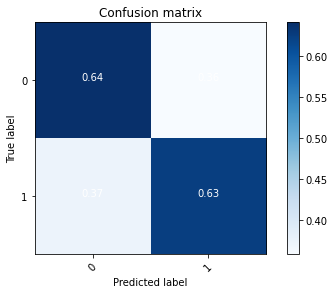

In [43]:
print_summary("LR_RO", lr_pipeline_ro)

Confusion matrix and classification report for model: RF_RO
              precision    recall  f1-score   support

           0       0.75      0.96      0.84    195504
           1       0.50      0.11      0.18     70153

    accuracy                           0.74    265657
   macro avg       0.62      0.54      0.51    265657
weighted avg       0.68      0.74      0.67    265657



DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd199c81c10>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd199c81c10>
DEBUG:matplotlib.colorbar:Setting pcolormesh


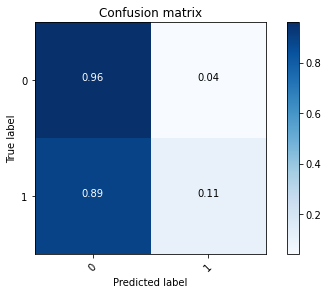

In [44]:
print_summary("RF", rf_pipeline)

Confusion matrix and classification report for model: LR_SMOTE
              precision    recall  f1-score   support

           0       0.83      0.60      0.70    195504
           1       0.37      0.65      0.47     70153

    accuracy                           0.62    265657
   macro avg       0.60      0.63      0.58    265657
weighted avg       0.71      0.62      0.64    265657



DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd199c5acd0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd199c5acd0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


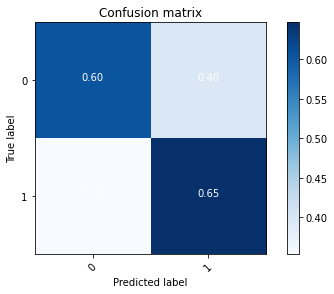

In [45]:
print_summary("LR_SMOTE", rf_pipeline_ru)

Confusion matrix and classification report for model: LGBM_RO
              precision    recall  f1-score   support

           0       0.81      0.62      0.70    195504
           1       0.36      0.60      0.45     70153

    accuracy                           0.61    265657
   macro avg       0.59      0.61      0.58    265657
weighted avg       0.69      0.61      0.64    265657



DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd199c3b4d0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd199c3b4d0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


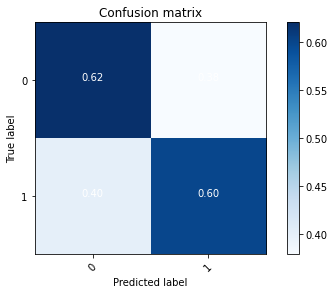

In [46]:
print_summary("LGBM_RO", lgbm_pipeline_ro)

Confusion matrix and classification report for model: LGBM
              precision    recall  f1-score   support

           0       0.75      0.96      0.84    195504
           1       0.48      0.11      0.18     70153

    accuracy                           0.73    265657
   macro avg       0.61      0.53      0.51    265657
weighted avg       0.68      0.73      0.67    265657



DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd199ba6e90>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd199ba6e90>
DEBUG:matplotlib.colorbar:Setting pcolormesh


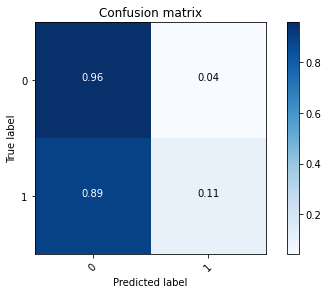

In [47]:
print_summary("LGBM", lgbm_pipeline)

The classification report and confusion matrix above give us more information about model's performance than simply printing
f1-score. We can see all metrics calculated for each class as well as how predictions are in terms of False Positive and False Negatives rates.

 - We can see how random forest and lightgbm alone cannot produce satisfactory results. They basically relies on predicting all instances as class zero. This demonstrates the effectiveness of using sampling techniques.
 - Logistic Regression model alone with class_balance parameter and random oversampling produced similar results.
 - Trade-off between recall and precision become clear here, when we increase recall, precision lowers for some class.
 
We can continue our analysis now by using ROC and Precision-Recall curves. They are used when output of interest is transformed to be a score (probability) of a given instance belonging to one of the classes used. All algorithms used actually give you a score instead of label instance, where logistic regression models return actual probabilities! (RF and LGBM need to be calibrated in order to return true probabilities, which I will not do it here, I will just pretend they are balanced scores, you can read more about it [here](https://scikit-learn.org/stable/modules/calibration.html))

At default, models output a class of label 1 if score is higher than 0.5, but we could change that. So basically, to motivate this we can think of two cases:
 - If threshold is chosen to be high, for example, around >0.8, we would have a lot of false negatives, i.e., predicting a propensity customer being a non-respondent.
 - On the other hand, if it is too relaxed, we would have a lot of false positives, i.e., we would say our customer are respondents when they are not actually.
 
ROC and Precision-Recall curves deals with that. ROC plots TPR (True Positive Rate) vs. FPR (False Positive Rate), which is a balance between what we discussed above. Precision-Recall curves plot Precision vs Recall given threshold t. ROC curves are easier to analyze since Precision-Recall curve is not necessarily monotonic. Then to assess model performance, we can calculate AUC (Area Under the Curve).

This is extremely useful for our case, because we want to rank our applicants instead of giving raw labels.

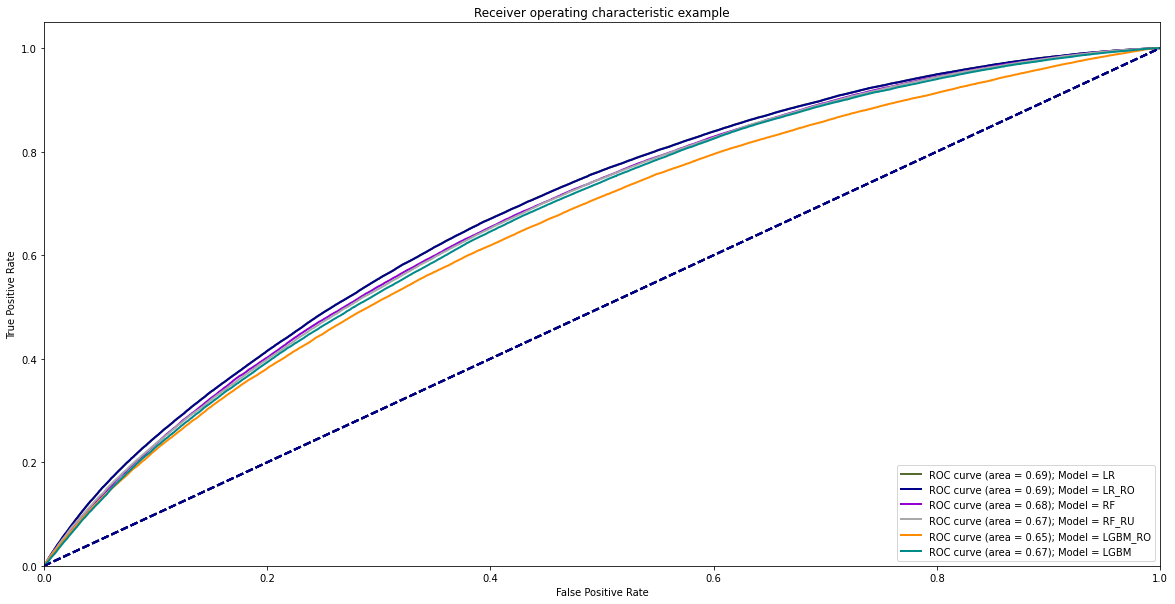

In [83]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(20, 10))

colors = ['darkcyan', 'darkorange', 'darkgrey', 'darkviolet', 'darkblue', 'darkolivegreen']
for model_name, model_pipeline in best_models.items():
    
    y_score = model_pipeline.predict_proba(test_temp[features])[:, 1]
    plot_roc_curve(test_temp[target], y_score, ax, color=colors.pop(), model_name=model_name)

We calculate AUC because since we have overlapping curves, that is, one model can start better than other, but at some point they invert their position, becomes difficult to assess models' quality. Surprisingly, we can see that Logistic Regression model with class balanced paremeter achives best score. Followed by all boosting / bagging models.

## Business Optimization

Up to now, we discussed our model assessment based on well-known scores used in ML world. However, we can and should give a sense of how these scores impact our business and the problem we want to solve. In one phrase: how much money do we expect in return for our models? To do that, we should build a cost-matrix, as the one shows below.

<table style="height: 146px; margin-left: auto; margin-right: auto;" width="466"><caption><strong>Cost Matrix for default prediction</strong></caption>
<tbody>
<tr>
<td style="width: 148px;">&nbsp;</td>
<td style="width: 148px;">Actual Default<br />y = 1</td>
<td style="width: 148.667px;">Actual Negative<br />y = 0</td>
</tr>
<tr>
<td style="width: 148px;">Predicted Default<br />y-hat = 1</td>
<td style="width: 148px;">Saving = <strong>total_loan_amount</strong> <strong>amount</strong></td>
<td style="width: 148.667px;">Cost = <strong>Customer</strong></td>
</tr>
<tr>
<td style="width: 148px;">Predicted Negative<br />y-hat = 0</td>
<td style="width: 148px;">Cost = Saving = <strong>total_loan_amount amount</strong></td>
<td style="width: 148.667px;">None&nbsp;</td>
</tr>
</tbody>
</table>

To simply, I assume the following:
 - If I classify a default application as a fully_paid one, incurred loss will be total loan amount.
 - If I classify a fully_paid application as a default one, I would loss a 10% that woul've come from transactions fees.
 - If I classify a fully_paid correctly, I would have a total profit of 10% in charges.
 - If I classify correctly a default case, I will say nothing happen. Although in reality would've been saving total_loan amount. But let keep things simple.

In [74]:
from prettytable import PrettyTable

def return_labels(model, X_test, threshold=0.5):
    probabilities = model.predict_proba(test[features])
    probabilities = probabilities[:, 1]
    probabilities[probabilities <= threshold] = 0
    probabilities[probabilities > threshold] = 1
    return probabilities

def print_cost_matrix(model, X_test, threshold=0.5):
    test = X_test.copy()
    
    total_savings = test[test['loan_status_general']==1]['total_loan_amount'].sum()
    test['predicted'] = return_labels(model, X_test, threshold)
    
    
    savings = test[(test.predicted==1) & (test['loan_status_general']==1)]['total_loan_amount'].sum()
    cost = test[(test.predicted==0) & (test['loan_status_general']==1)]['total_loan_amount'].sum()
    cost_customers = test[(test.predicted==1) & (test['loan_status_general']==0)]['loan_status_general'].count()
    
    t = PrettyTable(['', 'Actual Default', 'Actual Negative'])
    t.add_row(['Predicted Default', 'Savings:' + str(np.round(savings / total_savings, 3)), 
               'Percentage of denied customers: '+ str(np.round(cost_customers / test.shape[0], 3))])
    t.add_row(['Predicted Negative', 'Cost:' + str(np.round(cost /  total_savings, 3)), 0])
    print(t)
    
print_cost_matrix(lr_pipeline, test_temp, threshold=0.1)   

+--------------------+----------------+--------------------------------------+
|                    | Actual Default |           Actual Negative            |
+--------------------+----------------+--------------------------------------+
| Predicted Default  |  Savings:1.0   | Percentage of denied customers: 0.73 |
| Predicted Negative |    Cost:0.0    |                  0                   |
+--------------------+----------------+--------------------------------------+


Let's vary thrshold artifically so we can see the impact this parameter have on our business case.

In [79]:
for threshold in [0.5, 0.6, 0.75, 0.8, 0.9]:
    print_cost_matrix(lr_pipeline, test_temp, threshold=threshold)

+--------------------+----------------+---------------------------------------+
|                    | Actual Default |            Actual Negative            |
+--------------------+----------------+---------------------------------------+
| Predicted Default  | Savings:0.763  | Percentage of denied customers: 0.265 |
| Predicted Negative |   Cost:0.237   |                   0                   |
+--------------------+----------------+---------------------------------------+
+--------------------+----------------+---------------------------------------+
|                    | Actual Default |            Actual Negative            |
+--------------------+----------------+---------------------------------------+
| Predicted Default  |  Savings:0.55  | Percentage of denied customers: 0.129 |
| Predicted Negative |   Cost:0.45    |                   0                   |
+--------------------+----------------+---------------------------------------+
+--------------------+----------------+-

We can clearly see movement of cost, savings and denied customers as we vary our paramater. This happens because of precision-recall trade-off with higher thrsholds we are increasing our precision but lowering our recall.

In [80]:
for threshold in [0.5, 0.6, 0.75, 0.8, 0.9]:
    print_cost_matrix(rf_pipeline_ru, test_temp, threshold=threshold)

+--------------------+----------------+---------------------------------------+
|                    | Actual Default |            Actual Negative            |
+--------------------+----------------+---------------------------------------+
| Predicted Default  | Savings:0.758  | Percentage of denied customers: 0.291 |
| Predicted Negative |   Cost:0.242   |                   0                   |
+--------------------+----------------+---------------------------------------+
+--------------------+----------------+---------------------------------------+
|                    | Actual Default |            Actual Negative            |
+--------------------+----------------+---------------------------------------+
| Predicted Default  | Savings:0.551  | Percentage of denied customers: 0.158 |
| Predicted Negative |   Cost:0.449   |                   0                   |
+--------------------+----------------+---------------------------------------+
+--------------------+----------------+-

In [85]:
for threshold in [0.5, 0.6, 0.75, 0.8, 0.9]:
    print_cost_matrix(lgbm_pipeline_ro, test_temp, threshold=threshold)

+--------------------+----------------+---------------------------------------+
|                    | Actual Default |            Actual Negative            |
+--------------------+----------------+---------------------------------------+
| Predicted Default  | Savings:0.663  | Percentage of denied customers: 0.279 |
| Predicted Negative |   Cost:0.337   |                   0                   |
+--------------------+----------------+---------------------------------------+
+--------------------+----------------+---------------------------------------+
|                    | Actual Default |            Actual Negative            |
+--------------------+----------------+---------------------------------------+
| Predicted Default  | Savings:0.502  | Percentage of denied customers: 0.161 |
| Predicted Negative |   Cost:0.498   |                   0                   |
+--------------------+----------------+---------------------------------------+
+--------------------+----------------+-